In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
def data_spilt(data, orders, start):
    x_train = np.empty((len(data) - start - orders, orders))
    y_train = data[start + orders:]

    for i in range(len(data) - start - orders):
        x_train[i] = data[i + start:start + orders + i]

    # Exclude the day (Feb. 12, 2020) of the change of the definition of confirmed cases in Hubei China.
    x_train = np.delete(x_train, np.s_[28 - (orders + 1) - start:28 - start], 0)
    y_train = np.delete(y_train, np.s_[28 - (orders + 1) - start:28 - start])

    return x_train, y_train

In [3]:
def ridge(x, y):
    print('\nStart searching good parameters for the task...')
    parameters = {'alpha': np.arange(0, 0.100005, 0.000005).tolist(),
                  "tol": [1e-8],
                  'fit_intercept': [True, False],
                  'normalize': [True, False]}

    clf = GridSearchCV(Ridge(), parameters, n_jobs=-1, cv=5)
    clf.fit(x, y)

    print('\nResults for the parameters grid search:')
    print('Model:', clf.best_estimator_)
    print('Score:', clf.best_score_)
    return clf

In [4]:
df = pd.read_csv(r"F:\FYP\Final_Data(2022).csv")
df.head()

,Unnamed: 0,Province,Country_Region,Date,Day,Month,Year,Lat,Long_,Confirmed,...,admis_upper_vax,admis_lower_vax,admis_mean_unvax,admis_upper_unvax,admis_lower_unvax,Temp,Wind,Barometer,Visibility,Weather
0,0,Balochistan,Pakistan,2020-03-10,10,3,2020,28.328492,65.898403,1.0,...,0.0,0.0,25.615120,44.61881,10.791250,46.29,15.00,31.43,0.00,Haze.
1,1,Islamabad,Pakistan,2020-03-10,10,3,2020,33.665087,73.121219,2.0,...,0.0,0.0,0.004133,0.00000,0.000000,65.14,9.57,34.71,21.33,Clear.
2,2,Punjab,Pakistan,2020-03-10,10,3,2020,30.811346,72.139132,0.0,...,0.0,0.0,40.904370,89.53674,11.384460,56.40,2.44,23.67,11.88,Clear.
3,3,Sindh,Pakistan,2020-03-10,10,3,2020,26.009446,68.776807,0.0,...,0.0,0.0,22.339800,81.02134,6.179772,65.14,9.57,34.71,21.33,Clear.
4,4,Khyber Pakhtunkhwa,Pakistan,2020-03-10,10,3,2020,34.485332,72.091690,0.0,...,0.0,0.0,17.376130,39.58196,5.953569,48.80,4.64,49.20,23.21,Fog.


In [5]:
df_punjab = df[df["Province"] == "Punjab"]
df_punjab.reset_index(inplace = True)
df_punjab.head()

,index,Unnamed: 0,Province,Country_Region,Date,Day,Month,Year,Lat,Long_,...,admis_upper_vax,admis_lower_vax,admis_mean_unvax,admis_upper_unvax,admis_lower_unvax,Temp,Wind,Barometer,Visibility,Weather
0,2,2,Punjab,Pakistan,2020-03-10,10,3,2020,30.811346,72.139132,...,0.0,0.0,40.90437,89.53674,11.38446,56.40,2.44,23.67,11.88,Clear.
1,9,9,Punjab,Pakistan,2020-03-11,11,3,2020,30.811346,72.139132,...,0.0,0.0,54.93888,122.02440,18.87995,66.81,1.65,20.31,9.32,Clear.
2,16,16,Punjab,Pakistan,2020-03-12,12,3,2020,30.811346,72.139132,...,0.0,0.0,68.11369,138.27810,30.12372,53.31,4.90,53.12,18.58,Passing clouds.
3,23,23,Punjab,Pakistan,2020-03-13,13,3,2020,30.811346,72.139132,...,0.0,0.0,76.74755,139.84620,36.38107,56.46,6.56,77.27,27.94,Drizzle. Mostly cloudy.
4,30,30,Punjab,Pakistan,2020-03-14,14,3,2020,30.811346,72.139132,...,0.0,0.0,74.69784,130.49930,29.46047,56.56,5.71,43.00,19.36,Passing clouds.


In [6]:
########## data ##########
# data collected from https://voice.baidu.com/act/newpneumonia/newpneumonia
# X_cml = cumulative confirmed cases
X_cml = np.array(df_punjab["Confirmed"])[14:-50]
# recovered = cumulative recovered cases
recovered = np.array(df_punjab["Deaths"])[14:-50]
# death = cumulative deaths
death = np.array(df_punjab["Recovered"])[14:-50]

population = 110012442

In [7]:
########## data preprocess ##########
X = X_cml - recovered - death
R = recovered + death

n = np.array([population] * len(X))

S = n - X - R

X_diff = np.array([X[:-1], X[1:]]).T
R_diff = np.array([R[:-1], R[1:]]).T

gamma = (R[1:] - R[:-1]) / X[:-1]
beta = n[:-1] * (X[1:] - X[:-1] + R[1:] - R[:-1]) / (X[:-1] * (n[:-1] - X[:-1] - R[:-1]))
R0 = beta / gamma

In [8]:
########## Parameters for Ridge Regression ##########
##### Orders of the two FIR filters in (12), (13) in the paper. #####
orders_beta = 3
orders_gamma = 3

##### Select a starting day for the data training in the ridge regression. #####
start_beta = 10
start_gamma = 10

########## Print Info ##########
print("\nThe latest transmission rate beta of SIR model:", beta[-1])
print("The latest recovering rate gamma of SIR model:", gamma[-1])
print("The latest basic reproduction number R0:", R0[-1])

########## Ridge Regression ##########
##### Split the data to the training set and testing set #####
x_beta, y_beta = data_spilt(beta, orders_beta, start_beta)
x_gamma, y_gamma = data_spilt(gamma, orders_gamma, start_gamma)


The latest transmission rate beta of SIR model: 0.001944349429844715
The latest recovering rate gamma of SIR model: 0.001790346742665059
The latest basic reproduction number R0: 1.0860183580697962


In [9]:
##### Searching good parameters #####
# clf_beta = ridge(x_beta, y_beta)
# clf_gamma = ridge(x_gamma, y_gamma)

In [10]:
##### Training and Testing #####
clf_beta = Ridge(alpha=0.003765, copy_X=True, fit_intercept=False, max_iter=None, normalize=True, random_state=None, solver='auto', tol=1e-08).fit(x_beta, y_beta)
clf_gamma = Ridge(alpha=0.001675, copy_X=True, fit_intercept=False, max_iter=None,normalize=True, random_state=None, solver='auto', tol=1e-08).fit(x_gamma, y_gamma)

beta_hat = clf_beta.predict(x_beta)
gamma_hat = clf_gamma.predict(x_gamma)


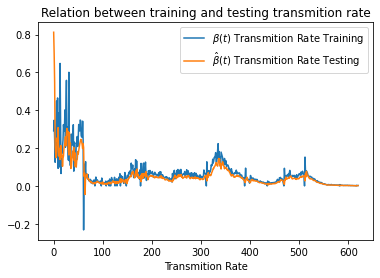

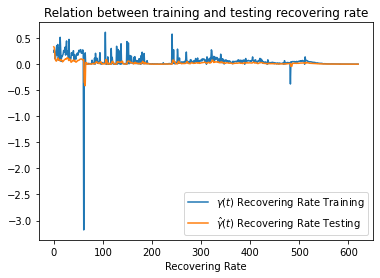

In [11]:
##### Plot the training and testing results #####
plt.figure(1)
plt.plot(y_beta, label=r'$\beta (t)$ Transmition Rate Training')
plt.plot(beta_hat, label=r'$\hat{\beta}(t)$ Transmition Rate Testing')
plt.xlabel('Transmition Rate')
plt.title('Relation between training and testing transmition rate')
plt.legend()

plt.figure(2)
plt.plot(y_gamma, label=r'$\gamma (t)$ Recovering Rate Training')
plt.plot(gamma_hat, label=r'$\hat{\gamma}(t)$ Recovering Rate Testing')
plt.xlabel('Recovering Rate')
plt.title('Relation between training and testing recovering rate')
plt.legend()

In [12]:
########## Time-dependent SIR model ##########

##### Parameters for the Time-dependent SIR model #####
stop_X = 0 # stopping criteria
stop_day = 100 # maximum iteration days (W in the paper)

day_count = 0
turning_point = 0

S_predict = [S[-1]]
X_predict = [X[-1]]
R_predict = [R[-1]]

predict_beta = np.array(beta[-orders_beta:]).tolist()
predict_gamma = np.array(gamma[-orders_gamma:]).tolist()
while (X_predict[-1] >= stop_X) and (day_count <= stop_day):
    if predict_beta[-1] > predict_gamma[-1]:
        turning_point += 1

    next_beta = clf_beta.predict(np.asarray([predict_beta[-orders_beta:]]))[0]
    next_gamma = clf_gamma.predict(np.asarray([predict_gamma[-orders_gamma:]]))[0]

    if next_beta < 0:
        next_beta = 0
    if next_gamma < 0:
        next_gamma = 0

    predict_beta.append(next_beta)
    predict_gamma.append(next_gamma)

    next_S = ((-predict_beta[-1] * S_predict[-1] *
               X_predict[-1]) / n[-1]) + S_predict[-1]
    next_X = ((predict_beta[-1] * S_predict[-1] * X_predict[-1]) /
              n[-1]) - (predict_gamma[-1] * X_predict[-1]) + X_predict[-1]
    next_R = (predict_gamma[-1] * X_predict[-1]) + R_predict[-1]

    S_predict.append(next_S)
    X_predict.append(next_X)
    R_predict.append(next_R)

    day_count += 1

In [13]:
########## Print Info ##########
print('\nConfirmed cases tomorrow in Punjab:', np.rint(X_predict[1] + R_predict[1]))
print('Infected persons tomorrow in Punjab:', np.rint(X_predict[1]))
print('Recovered + Death persons tomorrow in Punjab:', np.rint(R_predict[1]))

print('\nEnd day:', day_count)
print('Confirmed cases on the end day in Punjab:', np.rint(X_predict[-2] + R_predict[-2]))

print('\nTuring point in Punjab:', turning_point)


Confirmed cases tomorrow in Punjab: 444359.0
Infected persons tomorrow in Punjab: 27394.0
Recovered + Death persons tomorrow in Punjab: 416965.0

End day: 101
Confirmed cases on the end day in Punjab: 444628.0

Turing point in Punjab: 101


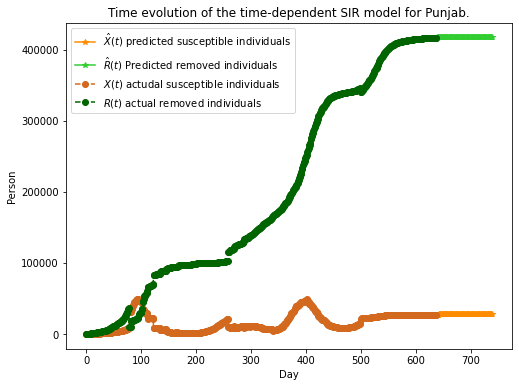

In [14]:
########## Plot the time evolution of the time-dependent SIR model ##########
plt.figure(3, figsize=(8, 6))
plt.plot(range(len(X) - 1, len(X) - 1 + len(X_predict)), X_predict, '*-', label=r'$\hat{X}(t)$ predicted susceptible individuals', color='darkorange')
plt.plot(range(len(X) - 1, len(X) - 1 + len(X_predict)), R_predict, '*-', label=r'$\hat{R}(t)$ Predicted removed individuals', color='limegreen')
plt.plot(range(len(X)), X, 'o--', label=r'$X(t)$ actudal susceptible individuals', color='chocolate')
plt.plot(range(len(X)), R, 'o--', label=r'$R(t)$ actual removed individuals', color='darkgreen')
plt.xlabel('Day')
plt.ylabel('Person')
plt.title('Time evolution of the time-dependent SIR model for Punjab.')

plt.legend()

plt.show()